In [1]:
# imports
import sys
import random
import operator 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 

from collections import defaultdict 
from sklearn import preprocessing 

# cadCAD-specific imports
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD.engine import ExecutionMode, ExecutionContext
from cadCAD.engine import Executor
from cadCAD import configs

# import geos-specific classes
sys.path.append('../module')

from geos import *

In [2]:
# configurations

# analysis
plt.rcParams['font.family'] = 'monospace'


In [3]:
# state macros 

## request
REQUEST_SUBMITTED = "submitted"
REQUEST_FULFILLED = "fulfilled"
REQUEST_EXPIRED = "expired"
SUBREQUEST_FULFILLED = "fulfilled"

## donation 
DONATION_SUBMITTED = "submitted"
DONATION_SELECTED = "selected"

## solver
SOLVER_BREAKDOWN = "breakdown"
SOLVER_MATCHMAKING = "matchmaking"
SOLVER_VALIDATION = "validation"

## receipts
RECEIPT_DONOR = "donor"
RECEIPT_REQUESTOR = "requestor"

## agents & solvers
SOLVER_TYPES = ["breakdown", "matchmaking", "validation"]
AGENT_TYPES = ["decentralization-conscious", "honest", "rational"]

In [4]:
# initialization data

MAX_QTY_RESOURCES = 2000000
COUNT_RESOURCES = 100

system_params = {
    'need_threshold': [0.8],
    'count_economies': 5, 
    'count_agents': 20,
    'count_solvers': 5,
    'count_resources': COUNT_RESOURCES, 
    'count_resource_dependencies': 5,
    'max_qty_resources': MAX_QTY_RESOURCES,
    'min_qty_resources': 100,
    'max_resource_count_agent': 50,
    'min_resource_count_agent': 20,
    'max_qty_resources_agent': 0.0005 * MAX_QTY_RESOURCES,
    'count_resources_1': int(0.3 * COUNT_RESOURCES),
    'count_resources_2': int(0.7 * COUNT_RESOURCES),
    'agent_types_probabilities': [0.1, 0.4, 0.5], # decentralization-conscious, honest, rational
    'solver_types_probabilities': [0.3, 0.7], # [0, 1] set whether the solver is global
    'resource_dependency_probabilities': [0.95, 0.05] # 
}


In [5]:
# initialize variables

economies = ["econ_" + str(i) for i in range(system_params['count_economies'])]

agents = init_agents(economies, system_params['count_agents'], system_params['agent_types_probabilities'])
solvers = init_solvers(economies, system_params['count_solvers'], system_params['solver_types_probabilities'])

print(agents)
inventory = Inventory()
resources = init_resources(system_params['count_resources_1'], system_params['count_resources_2'], system_params['resource_dependency_probabilities'])

for resource_id, resource in resources.items():
    quantity = random.randint(system_params['min_qty_resources'], system_params['max_qty_resources'])
    inventory.add_resource(resource_id, resource, quantity, quantity) # full stock availability


agents, inventory = distribute_inventory(agents, system_params['min_resource_count_agent'], system_params['max_resource_count_agent'], inventory) #,system_params['max_qty_resources_agent'])
idling_capacity_overall, idling_capacity_by_resource = calculate_cumulative_idling_capacity(inventory, agents)

{'agent_0': <geos.Agent object at 0x7fc692d55d30>, 'agent_1': <geos.Agent object at 0x7fc692d55c70>, 'agent_2': <geos.Agent object at 0x7fc692d55bb0>, 'agent_3': <geos.Agent object at 0x7fc692d550d0>, 'agent_4': <geos.Agent object at 0x7fc692d556d0>, 'agent_5': <geos.Agent object at 0x7fc6a0918130>, 'agent_6': <geos.Agent object at 0x7fc6a0918610>, 'agent_7': <geos.Agent object at 0x7fc6a0918a90>, 'agent_8': <geos.Agent object at 0x7fc6a09185e0>, 'agent_9': <geos.Agent object at 0x7fc6a09188b0>, 'agent_10': <geos.Agent object at 0x7fc6a0918700>, 'agent_11': <geos.Agent object at 0x7fc6a09188e0>, 'agent_12': <geos.Agent object at 0x7fc6a0918c10>, 'agent_13': <geos.Agent object at 0x7fc6a0918730>, 'agent_14': <geos.Agent object at 0x7fc6a0918d60>, 'agent_15': <geos.Agent object at 0x7fc6a0918dc0>, 'agent_16': <geos.Agent object at 0x7fc6a09186a0>, 'agent_17': <geos.Agent object at 0x7fc6a09189d0>, 'agent_18': <geos.Agent object at 0x7fc6a0918970>, 'agent_19': <geos.Agent object at 0x7fc6

In [6]:
# TODO wrap as function (also apply to metrics update policy)
decentralization_indices = defaultdict(lambda: {})

for resource_id in inventory.stock.keys():
    decentralization_indices[resource_id] = {}
    ci = calculate_concentration_index(resource_id, agents)
    di = calculate_distribution_index(resource_id, agents, system_params['count_agents'])
    decentralization_indices[resource_id]["concentration_index"] = ci
    decentralization_indices[resource_id]["distribution_index"] = di
    decentralization_indices[resource_id]["decentralization_index"]= calculate_decentralization_index(di, ci)

In [7]:
# TODO: wrap as function

solvers_by_economy = defaultdict(lambda: [])

for economy in economies:
    for solver_id, solver in solvers.items():
        if economy in solver.economies:
            solvers_by_economy[economy].append(solver_id)
        if "global" in solver.economies:
            solvers_by_economy[economy].append(solver_id)
    solvers_by_economy[economy] = list(set(solvers_by_economy[economy]))

In [8]:
# initial state

initial_state = {
    'requests': {}, # resource requests by their id
    'donation_responses': {}, # all announced donations by id
    'inventory': inventory, # available (undistributed) resources
    'agents': agents, # agents with their inventories; includes solvers
    'donation_receipts': {}, # proofs of donation by request id
    'strategies': {}, # selected donation(s) by request id
    'solvers': solvers,
    'solvers_by_economy': solvers_by_economy,
    'requests_pool': {},
    'receipts_pool': {},
    'requests_fulfilled_pool': {},
    'metrics': {
        'throughput': 0, # total requests solved
        'average_latency': 0.0, # average request resolution over timesteps
        'decentralization_index': decentralization_indices, # concentration, distribution, and decentralization indices for each resource
        'cumulative_idling_capacity': idling_capacity_overall, # idle / available (the lower the better as resources are used; however, open requests must be considered for discussion)
        'cumulative_idling_capacity_by_resource': idling_capacity_by_resource,
        'poa': None, # TBD
        'waste_rate': None, # TBD
    }
}

print(f"Initial State: {initial_state}")

Initial State: {'requests': {}, 'donation_responses': {}, 'inventory': <geos.Inventory object at 0x7fc692d557f0>, 'agents': {'agent_0': <geos.Agent object at 0x7fc692d55d30>, 'agent_1': <geos.Agent object at 0x7fc692d55c70>, 'agent_2': <geos.Agent object at 0x7fc692d55bb0>, 'agent_3': <geos.Agent object at 0x7fc692d550d0>, 'agent_4': <geos.Agent object at 0x7fc692d556d0>, 'agent_5': <geos.Agent object at 0x7fc6a0918130>, 'agent_6': <geos.Agent object at 0x7fc6a0918610>, 'agent_7': <geos.Agent object at 0x7fc6a0918a90>, 'agent_8': <geos.Agent object at 0x7fc6a09185e0>, 'agent_9': <geos.Agent object at 0x7fc6a09188b0>, 'agent_10': <geos.Agent object at 0x7fc6a0918700>, 'agent_11': <geos.Agent object at 0x7fc6a09188e0>, 'agent_12': <geos.Agent object at 0x7fc6a0918c10>, 'agent_13': <geos.Agent object at 0x7fc6a0918730>, 'agent_14': <geos.Agent object at 0x7fc6a0918d60>, 'agent_15': <geos.Agent object at 0x7fc6a0918dc0>, 'agent_16': <geos.Agent object at 0x7fc6a09186a0>, 'agent_17': <geos.

In [9]:
# substep 1

def p_update_inventory_policy(params, substep, state_history, previous_state):
    '''
    update individual agents' inventories by:
        1. consumption (decreases stocks)
        2. acquisition (increases individual stocks, decreases global stocks)
        3. updating inventory policy (increase/decrease idle stocks by resource)
    current implementation: 
        - random update of max. 5 resources per agent per state per action
        - (3) not implemented
        - to add: other changes to global stock
    '''

    agents = previous_state['agents']
    inventory = previous_state['inventory']

    new_agent_stocks = defaultdict(lambda: [])
    new_inventory = defaultdict(lambda: {})
    consumption = defaultdict(lambda: [])

    # (1) consumption
    for agent_id, agent in agents.items():

        consumption_count = random.randint(0, 5) # TODO system parameter
        consumption_choices = random.sample(list(agent.inventory.stock.keys()), consumption_count)

        for resource_id in consumption_choices:
            if agent.inventory.stock[resource_id]["quantity"] > 0: # consume if enough stock
                consumption_quantity = random.randint(1, agent.inventory.stock[resource_id]["quantity"]) # consume from quantity (i.e., in-use, not idle stock)
                consumption[agent_id].append({
                    "resource_id": resource_id,
                    "quantity": consumption_quantity
                })

    # (2) external acquisition 
    for agent_id, agent in agents.items():

        acquisition_count = random.randint(0, 5) # TODO system parameter
        acquisition_choices = random.sample(list(inventory.stock.keys()), acquisition_count)

        for resource_id in acquisition_choices:
            if inventory.stock[resource_id]["idle_stock"] > 1:

                # TODO update: right now qty cannot go to 0 (else it affects metrics (division by zero)) s.t. min qty of global stock is 1
                # acquisition only from idle stock
                acquisition_quantity = random.randint(1, min(inventory.stock[resource_id]["idle_stock"] - 1, 500)) 

                inventory.stock[resource_id]["idle_stock"] -= acquisition_quantity # local update, not applied to state
                inventory.stock[resource_id]["quantity"] -= acquisition_quantity # local update, not applied to state
            
                new_inventory[resource_id] = {
                    "quantity": inventory.stock[resource_id]["quantity"], 
                    "idle_stock": inventory.stock[resource_id]["idle_stock"]
                }
         
                new_agent_stocks[agent_id].append({
                    "resource_id": resource_id,
                    "quantity": acquisition_quantity
                })

    # (3) usage strategy
    # TODO

    return {'new_agent_stocks': new_agent_stocks, 'new_inventory': new_inventory, 'consumption': consumption}

def s_update_inventory_policy(params, substep, state_history, previous_state, policy_input):
    '''
    applies updates to agent inventories based on consumption/acquisition/changes in inventory policy
    '''

    resources = previous_state['inventory']

    agents_new = previous_state['agents'].copy()

    consumption = policy_input['consumption']
    new_agent_stocks = policy_input['new_agent_stocks']

    # apply consumption
    for agent_id, stocks in consumption.items():
        for stock in stocks:
            resource_id = stock["resource_id"]
            agents_new[agent_id].inventory.stock[resource_id]["quantity"] -= stock["quantity"]
   
    # apply acquisition
    for agent_id, stocks in new_agent_stocks.items():
        for stock in stocks:
            resource_id = stock["resource_id"]
            if resource_id in agents_new[agent_id].inventory.stock.keys():
                agents_new[agent_id].inventory.stock[resource_id]["quantity"] += stock["quantity"]
            else:
                agents_new[agent_id].inventory.stock[resource_id] = {
                    "resource": resources.stock[resource_id]["resource"],
                    "quantity": stock["quantity"],
                    "idle_stock": 0, 
                    "locked": 0
                }
            
    # apply usage strategy changes
    # TODO

    return ('agents', agents_new)

def s_update_global_stocks(params, substep, state_history, previous_state, policy_input):
    '''
    updates global stocks based on acquisitions by agents
    TODO update based on other types of changes (e.g., resource decay)
    '''

    inventory_new = previous_state['inventory'].make_copy()
    new_inventory = policy_input['new_inventory']

    for resource_id in new_inventory.keys():
        inventory_new.stock[resource_id]["quantity"] = new_inventory[resource_id]["quantity"]
        inventory_new.stock[resource_id]["idle_stock"] = new_inventory[resource_id]["idle_stock"]

    return ('inventory', inventory_new)


In [10]:
# substep 2

def p_submit_request(params, substep, state_history, previous_state):
    '''
    agent submits request for a resource
    current implementation: 
        - randomly decide whether to submit request
        - random choice of resource requested
        - picks solver for request from within agents' economies (or global if not applicable) TODO: expand solver logic throughout model
    returns a dictionary of requests by all agents during a given state
    '''

    agents = previous_state['agents']
    requests = previous_state['requests'] 
    resources = previous_state['inventory'].stock 

    need_threshold = params['need_threshold']
    solvers_by_economy = previous_state['solvers_by_economy']

    complex_requests = {}

    for agent_id in agents:
        need = np.random.normal(size=1)[0] # determine need, i.e., if request will be submitted

        if need >= need_threshold:
            
            # prepare request data
            request_id = "request_" + str(len(requests))

            # randomize resource needed and quantity
            resource_id = random.choice(list(resources.keys()))
            quantity = np.random.randint(1, 500) # TODO system param (alternative: max resource qty at given time in system) 

            economy_id = random.choice(agents[agent_id].economies)
            solver_id = random.choice(solvers_by_economy[economy_id]) # pick solver for request
            
            # compile request
            request = Request(request_id, resource_id, quantity, agent_id, [], resources[resource_id]['resource'].rtype, solver_id)

            requests[request_id] = request

            # for complex requests, prepare for request breakdown in next substep
            if request.rtype == "complex":
                complex_requests[request_id] = request

    return {'new_requests': requests, 'pending_requests': complex_requests}


def p_donation_response(params, substep, state_history, previous_state):
    '''
    compile donation responses to requests in previous states
    each agent queries all requests and determines whether they can donate (acc. to their inventory policy)
    '''

    agents = previous_state['agents']
    requests = previous_state['requests']
    donations = previous_state['donation_responses']

    donation_responses = {}

    for agent_id, agent in agents.items():

        for request_id, request in requests.items():
            if request.state == REQUEST_SUBMITTED: # only active requests, i.e., not fulfilled (or expired)

                # check that current agent is not already donor to same request
                # TODO: move to function
                already_donated = False 
                for donation_id, donation in donations.items():
                    if donation.request_id == request_id:
                        if donation.donor == agent_id:
                            already_donated = True

                if not already_donated:
                    # only atomic/subrequests (complex ones are solved through corresponding subrequests)
                    if request.rtype == "atomic" or request.rtype == "subrequest":
                        if agent_id != request.requestor: # exclude self-donations
                            if request.resource_id in agent.inventory.stock.keys(): # if agent has requested resource
                                # TODO FIX look into donating the same resource in one timestep (must locally decrease stocks, else stock can go negative in one timestep)
                                if agent.inventory.stock[request.resource_id]["idle_stock"] > 0: # if agent has enough of the requested resource
                                
                                    # prepare donation data
                                    donation_id = "donation_" + str(len(donations) + len(donation_responses))
                                    donation_quantity = min(request.quantity, agent.inventory.stock[request.resource_id]['idle_stock'])
                                    
                                    # compile donation
                                    donation = DonationResponse(donation_id, agent_id, request_id, donation_quantity, [])
                                    
                                    donation_responses[donation_id] = donation
    
    return {'pending_donations': donation_responses}


def p_donation_receipt(params, substep, state_history, previous_state):
    '''
    agents submit receipts for received/fulfilled donations (as requestor and donor, respectively)
    TODO: implement donation withdrawal/qty alterations
    '''

    agents = previous_state['agents']
    requests = previous_state['requests']
    strategies = previous_state['strategies']
    receipts = previous_state['donation_receipts']
    
    pending_receipts = {}

    for agent_id in agents: 
        # each agent queries all strategies 
        for request_id, strategy_array in strategies.items(): 
            
            # for a given strategy, break if the agent has already sent a receipt
            receipt_sent = False
            for past_receipt_id in agents[agent_id].receipts:
                if receipts[past_receipt_id].request_id == request_id:
                    receipt_sent = True
           
            # if the agent hasn't sent a receipt for a given request
            # and the request is not yet fulfilled # TODO: check if second condition still needed
            if receipt_sent == False and requests[request_id].state == REQUEST_SUBMITTED:
                # for the donations in the strategy for fulfilling the respective request
                for strategy in strategy_array:
                    # check whether the current agent is the donor or requestor (i.e., whether the donation has been made or request submitted by current agent)
                    if agent_id == strategy.donor or agent_id == requests[request_id].requestor:
        
                        # determine whether donor or requestor receipt (depends on who the agent is)
                        rtype = ""
                        if agent_id == strategy.donor: 
                            rtype = RECEIPT_DONOR
                        
                        # TODO: simplify logic
                        elif agent_id == requests[request_id].requestor: 
                            rtype = RECEIPT_REQUESTOR
                            
                        # prepare receipt data
                        # current implementation: no qty deviation relative to donation response selected in strategy
                        quantity = strategy.quantity
                        receipt_id = "receipt_" + str(len(receipts) + len(pending_receipts))
                        # TODO expand use of solvers
                        solver_id = requests[request_id].solver_id
                        resource_id = requests[request_id].resource_id

                        # compile receipt
                        receipt = DonationReceipt(receipt_id, agent_id, request_id, rtype, solver_id, quantity, resource_id)

                        pending_receipts[receipt_id] = receipt

    return {'pending_receipts': pending_receipts}


def s_donation_response(params, substep, state_history, previous_state, policy_input):
    '''
    add new donation responses to state
    '''

    pending_donations = policy_input['pending_donations']
    donation_responses_new = previous_state['donation_responses'].copy()

    for donation_id, donation in pending_donations.items():
        donation_responses_new[donation_id] = donation 
    
    return ('donation_responses', donation_responses_new)


def s_donation_receipt(params, substep, state_history, previous_state, policy_input):
    '''
    add new receipts to state
    '''

    new_receipts = policy_input['pending_receipts']
    receipts_new = previous_state['donation_receipts'].copy()

    for receipt_id, receipt in new_receipts.items():
        receipts_new[receipt_id] = receipt

    return ('donation_receipts', receipts_new)

def s_donation_receipt_pool(params, substep, state_history, previous_state, policy_input):
    '''
    add new receipts to receipt pool
    '''

    new_receipts = policy_input['pending_receipts']
    receipts_new = previous_state['receipts_pool'].copy()
    
    for receipt_id, receipt in new_receipts.items():
        receipts_new[receipt_id] = receipt

    return ('receipts_pool', receipts_new)

def s_agent_receipts(params, substep, state_history, previous_state, policy_input):
    '''
    add new receipts to the respective agent's state
    '''
    
    new_receipts = policy_input['pending_receipts']
    agents_new = previous_state['agents'].copy()

    for receipt_id, receipt in new_receipts.items():
        agent_id = receipt.agent_id

        agents_new[agent_id].receipts.append(receipt_id)

    return ('agents', agents_new)

def s_new_request(params, substep, state_history, previous_state, policy_input):
    '''
    add new requests to the state
    '''

    pending_requests = policy_input['new_requests']
    requests_new = previous_state['requests'].copy()

    for request_id in pending_requests.keys():
        requests_new[request_id] = pending_requests[request_id]

    return ('requests', requests_new)

def s_request_pool(params, substep, state_history, previous_state, policy_input):
    '''
    add new requests to the request pool (to be later broken down into subrequests if necessary)
    '''

    pending_requests = policy_input['pending_requests']
    request_pool_new = previous_state['requests_pool'].copy()

    for request_id in pending_requests.keys():
        request_pool_new[request_id] = pending_requests[request_id]

    return ('requests_pool', request_pool_new)

In [11]:
# substep 3 helper
def build_strategy(options, required_quantity):
    '''
    build donation strategy based on options (i.e., donation responses to a request) and the required qty
    TODO add multiple strategy methods
    TODO add constraints
    TODO deal with overdonation by updating the quantity in the last donation in global state
    '''

    initial_quantity = required_quantity

    strategy = []
    running_sum = 0

    # source: https://ioflood.com/blog/python-sort-dictionary-by-value/
    # sort donations by qty (decreasing order (optimizes for least amount of donations))
    quantities = dict(sorted(options.items(), key=operator.itemgetter(1), reverse=True))

    # keep selecting donations until required quantity is reached
    for donation_id, quantity in quantities.items():
       
        if running_sum >= initial_quantity:
            break
    
        strategy.append(donation_id)
        running_sum += quantity

    # also returns qty over
    return strategy, initial_quantity - running_sum

In [12]:
# substep 3

def p_request_breakdown(params, substep, state_history, previous_state):
    '''
    method to break down complex requests into multiple subrequests based on dependent resources
    TODO add more dependency depth (or consider current design as flattened array)
    '''

    requests = previous_state['requests']
    inventory = previous_state['inventory']
    requests_pool = previous_state['requests_pool'] # previous state within same substep
    
    cleared = []
    subrequests = {}
    
    for request_id, request in requests_pool.items():
       
        resource_id = request.resource_id
        ctr = 0 # keep track of subrequest id

        # for each dependency of the requested resource compile a new request
        for dependency in inventory.stock[resource_id]["resource"].dependencies:

            # prepare subrequest data
            resource_id = dependency
            subrequest_id = request_id + "_" + str(ctr)
            # cap qty of subrequest to qty of main request
            # TODO allow flexible mappings of necessary qty
            subrequest_quantity = random.choice(range(1, request.quantity + 1))
            
            # compile subrequest
            subrequest = Request(subrequest_id, resource_id, subrequest_quantity, request.requestor, [], "subrequest", request.solver_id)
            
            # prepare to update the request's dependencies
            request.subrequests.append(subrequest)

            # prepare to update requests
            subrequests[subrequest_id] = subrequest

            ctr += 1

        # keep track of processed requests
        cleared.append(request_id)

    return {'subrequests': subrequests, 'cleared': cleared}

def p_receipts_match(params, substep, state_history, previous_state):
    '''
    match receipts in receipts pool corresponding to the same request
    when a complete match is available (i.e., for all subrequests/donation pairs), mark request for fulfillment
    '''
    
    requests = previous_state['requests']
    strategies = previous_state['strategies']
    receipts = previous_state['receipts_pool']
    
    requests_receipts = {}
    fulfilled_requests = []

    # get requestor receipts
    for receipt_id, receipt in receipts.items():
        if receipt.rtype == RECEIPT_REQUESTOR:

            request_id = receipt.request_id

            requests_receipts[request_id] = {
                "expected_receipts": len(strategies[request_id]), 
                "expected_quantity": requests[request_id].quantity # TODO FIX: current implementation overdonations for last donation allowed
            }


    # for each request with a requestor receipt look for matching donor receipt(s) (number and quantity)
    for request_id in requests_receipts.keys():
    
        qty = 0
        donors = []
        donation_receipts_count = 0
        
        for receipt_id, receipt in receipts.items():
            if request_id == receipt.request_id: # if matching receipt for request
                # if receipt from donor
                # if new donor than previous matching donor receipts
                if receipt.rtype == RECEIPT_DONOR and receipt.agent_id not in donors:
        
                    donors.append(receipt.agent_id)
                    donation_receipts_count += 1
                    qty += receipt.quantity 

        # if conditions for matching receipt(s) met 
        # TODO FIX: qty should be equal after fix (current implementation allowes overdonation by last donation in multi-donation strategies)
        if donation_receipts_count == requests_receipts[request_id]["expected_receipts"] and qty >= requests_receipts[request_id]["expected_quantity"]:
          
            fulfilled_requests.append(request_id) # mark request as completed

    fulfilled_requests = set(fulfilled_requests) # TODO check if still necessary line

    return {'pending_requests_fulfilled': fulfilled_requests}

def p_donation_strategies(params, substep, state_history, previous_state):
    '''
    compile donation strategies for each request based on corresponding donation responses
    if a single donation does not suffice to match the quantity in a request, 
    compile multi-donation strategies
    TODO FIX: currently qty of last donation in multi-donation can lead to overdonation
    TODO optimize/simplify logic
    TODO add multiple strategy construction methods (based on different constraints)
    '''

    requests = previous_state['requests']
    pending_donations = previous_state['donation_responses']

    strategies = defaultdict(lambda: [])
    selected_strategies = defaultdict(lambda: [])

    # if no strategy for a given request
    # collect all corresponding donations
    for donation_id in pending_donations.keys():

        req_id = pending_donations[donation_id].request_id

        if requests[req_id].strategy_added == False: 
            strategies[req_id].append(donation_id)

    # for each request for which a strategy does not exist
    for request_id in strategies.keys():
    
        # check if a strategy can be assembled, i.e., the sum of existing donation quantities is sufficient
        options = {}
        sum_donations = 0

        # sum up all donation quantities
        for donation_id in strategies[request_id]:
            if pending_donations[donation_id].state != DONATION_SELECTED:

                options[donation_id] = pending_donations[donation_id].quantity
                sum_donations += pending_donations[donation_id].quantity
        
        if sum_donations >= requests[request_id].quantity:
    
            # keep track of quantity over to be addressed
            s, over = build_strategy(options, requests[request_id].quantity)
            
            for donation_id in s:
                selected_strategies[request_id].append(pending_donations[donation_id])
    
    return {'pending_strategies': selected_strategies}

def s_donation_strategies(params, substep, state_history, previous_state, policy_input):
    '''
    apply new donation strategies if no strategy already exists
    TODO optimize to verify in previous step that no strategy exists
    '''

    strategies_new = previous_state['strategies'].copy()
    new_strategies = policy_input['pending_strategies']
    
    for request_id, donations in new_strategies.items():
        if request_id not in strategies_new.keys(): # if no strategy yet for given request
            strategies_new[request_id] = donations 
        
    return ('strategies', strategies_new)

def s_donation_responses_old(params, substep, state_history, previous_state, policy_input):
    '''
    update the state of donation responses selected for strategies
    current implementation: non-selected donation responses are not discarded as they should be used when
    donation withdrawals occur (to be implemented) to supplement strategy
    '''

    strategies = policy_input['pending_strategies']
    donation_responses_new = previous_state['donation_responses'].copy()
    
    # for pending strategies, mark contained donations as selected
    for request_id, donations in strategies.items():
        for donation in donations:
            donation_responses_new[donation.id].state = DONATION_SELECTED
    
    return ('donation_responses', donation_responses_new)


def s_lock_quantities(params, substep, state_history, previous_state, policy_input):
    '''
    update agents' inventories to reflect quantities "locked" by selected donations
    '''

    requests = previous_state['requests']
    agents_new = previous_state['agents'].copy()
    strategies = policy_input['pending_strategies']

    for request_id, donations in strategies.items():
        for donation in donations: 
            request_id = donation.request_id
            resource_id = requests[request_id].resource_id

            agents_new[donation.donor].inventory.stock[resource_id]["locked"] += donation.quantity # update locked stock
            agents_new[donation.donor].inventory.stock[resource_id]["idle_stock"] -= donation.quantity # decrease amount of available stock

    return ('agents', agents_new)

# TODO change name to reflect dual functionality (requests fulfilled, new requests as a consequence of request breakdown)
def s_request_breakdown(params, substep, state_history, previous_state, policy_input):
    '''
    updates the state of requests by adding new requests (subrequests submitted after breaking down ones for complex resources)
    at the same time, updates the state of existing requests to fulfilled if they
    also marks requests for which strategies exist
    TODO simplify verification of existing strategy when preparing one based on .strategy_added field in requests
    TODO update expired requests (must implement request deadlines)
    '''
    
    subrequests = policy_input['subrequests']
    requests_new = previous_state['requests'].copy()
    strategies_added = policy_input['pending_strategies']
    pending_requests_fulfilled = policy_input['pending_requests_fulfilled']

    # add new requests (subrequests)
    for request_id in subrequests.keys():
        requests_new[request_id] = subrequests[request_id]

    # updated fulfilled requests
    for request_id in pending_requests_fulfilled:
        requests_new[request_id].state = REQUEST_FULFILLED

    # update requests with strategies
    for request_id in strategies_added.keys():
        requests_new[request_id].strategy_added = True

    return ('requests', requests_new)

def s_requests_fulfilled_pool(params, substep, state_history, previous_state, policy_input):
    '''
    update the pool of fulfilled requests based on the pool of pending requests
    supports updating of stocks in the next substep based on fulfilled requests
    '''

    requests = previous_state['requests']
    requests_pool_new = previous_state['requests_fulfilled_pool'].copy()
    pending_requests_fulfilled = policy_input['pending_requests_fulfilled']

    for request_id in pending_requests_fulfilled:
        requests_pool_new[request_id] = requests[request_id]

    return ('requests_fulfilled_pool', requests_pool_new)

def s_receipts_pool_clear(params, substep, state_history, previous_state, policy_input):
    '''
    removes from the pool of receipts the ones that contributed to a fulfilled request
    TODO simplify logic by keeping track of obsolete receipts in matching
    '''

    receipts_pool_new = previous_state['receipts_pool'].copy()
    pending_requests_fulfilled = policy_input['pending_requests_fulfilled']

    removable_receipts = []

    # find all obsolete receipts (that have been employed to fulfill a request)
    for request_id in pending_requests_fulfilled:
        for receipt_id, receipt in receipts_pool_new.items():
            if receipt.request_id == request_id:
                removable_receipts.append(receipt_id)
                
    # remove receipts from pool
    for receipt_id in removable_receipts:    
        del receipts_pool_new[receipt_id]

    return ('receipts_pool', receipts_pool_new)

def s_clear_pool(params, substep, state_history, previous_state, policy_input):
    '''
    clear the pool of complex requests which have now been broken down into subrequests
    '''

    cleared_requests =  policy_input['cleared']
    requests_pool_new = previous_state['requests_pool'].copy()
    
    for request_id in cleared_requests:
        del requests_pool_new[request_id]

    return ('requests_pool', requests_pool_new)


In [13]:
# substep 4

def p_update_stocks(params, substep, state_history, previous_state):
    '''
    update agents' inventories based on fulfilled requests 
    increase stock if requestor
    decrease stock if donor
    handles the situation where an agent both donates and receives the same resource within the same timestep (marks change as increase/decrease)
    TODO integrate donations from system stock
    '''

    receipts = previous_state['donation_receipts']
    fulfilled_requests = previous_state['requests_fulfilled_pool']

    new_agents_stocks = defaultdict(lambda: [])
    
    # handles situations where an agent both donates and receives the same resource within the same timestep
    # for each fulfilled request, mark decrease (donor) or increase (requestor)
    # determine agent based on receipt rtype
    for request_id in fulfilled_requests:
        for receipt_id, receipt in receipts.items():
            if receipt.request_id == request_id:

                if receipt.rtype == RECEIPT_DONOR:
                    new_agents_stocks[receipt.agent_id].append({"resource_id": receipt.resource_id, "quantity": receipt.quantity, "operation": "decrease"})
                    
                elif receipt.rtype == RECEIPT_REQUESTOR:
                    new_agents_stocks[receipt.agent_id].append({"resource_id": receipt.resource_id, "quantity": receipt.quantity, "operation": "increase"})

    return {'new_agents_stocks': new_agents_stocks} 

def s_update_stocks(params, substep, state_history, previous_state, policy_input):
    '''
    apply changes to agents' stocks to state
    '''

    resources = previous_state['inventory']
    agents_new = previous_state['agents'].copy()
    new_agents_stocks = policy_input['new_agents_stocks']
    
    # for all changes to agents' stocks, apply as decrease/increase
    for agent_id, new_stocks in new_agents_stocks.items():
        for new_stock in new_stocks:

            if new_stock["operation"] == "decrease": # decrease qty, idle_stock, and remove lock for donated qty
                agents_new[agent_id].inventory.stock[new_stock["resource_id"]]["quantity"] -= new_stock["quantity"]
                agents_new[agent_id].inventory.stock[new_stock["resource_id"]]["idle_stock"] -= new_stock["quantity"]
                agents_new[agent_id].inventory.stock[new_stock["resource_id"]]["locked"] -= new_stock["quantity"]

            elif new_stock["operation"] == "increase": # increase qty or add as new resource

                if new_stock["resource_id"] not in agents_new[agent_id].inventory.stock.keys(): # if new resource

                    resource_id = new_stock["resource_id"]

                    agents_new[agent_id].inventory.stock[new_stock["resource_id"]] = {
                        "resource": resources.stock[resource_id]["resource"],
                        "quantity": new_stock["quantity"], # received qty
                        "idle_stock": 0, # 0 since requested necessary qty
                        "locked": 0 # no donation pending
                        }
                    
                else: # if resource already in inventory, update qty; no change to idle stock/locked qty
                    agents_new[agent_id].inventory.stock[new_stock["resource_id"]]["quantity"] += new_stock["quantity"]

    return ('agents', agents_new)

def s_clear_requests_fulfilled_pool(params, substep, state_history, previous_state, policy_input):
    '''
    clear pool of fulfilled requests now processed to update agents' stocks
    '''

    requests_fulfilled = previous_state['requests_fulfilled_pool']
    requests_fulfilled_pool_new = previous_state['requests_fulfilled_pool'].copy()
    
    for request_id in requests_fulfilled:
        del requests_fulfilled_pool_new[request_id]

    return ('requests_fulfilled_pool', requests_fulfilled_pool_new)




In [14]:
# substep 5

def calculate_average_request_fulfillment_latency(state_history):
    '''
    calculate request completion latency
    determine the latency for each request (state submitted vs state fulfilled)
    computes average
    '''
  
    latencies = []
    latency_by_request_fulfilled = {}

    for state_id in range(len(state_history)): # for each state
        for substep_id in range(len(state_history[state_id])):
            for request_id, request in state_history[state_id][substep_id]['requests'].items(): # for each request

                if request_id not in latency_by_request_fulfilled: # (for each request not accounted for yet)

                    latency_by_request_fulfilled[request_id] = {
                        "submitted": float(state_id), # state when submitted
                        "fulfilled": -1,
                    }
                
                # mark when request fulfilled
                if request.state == REQUEST_FULFILLED and latency_by_request_fulfilled[request_id]["fulfilled"] == -1:
                    latency_by_request_fulfilled[request_id]["fulfilled"] = float(state_id) 

    # find latency per request
    for request_id in latency_by_request_fulfilled.keys():
        if latency_by_request_fulfilled[request_id]["fulfilled"] > -1:

            latency = latency_by_request_fulfilled[request_id]["fulfilled"] - latency_by_request_fulfilled[request_id]["submitted"]
            latencies.append(latency)

    # if no requests fulfilled (for initial state)
    if len(latencies) == 0:
        return 0.0

    return round(sum(latencies) / len(latencies), 2) # avg latency

def p_update_metrics(params, substep, state_history, previous_state):
    '''
    compute new values of metrics
    '''

    agents = previous_state['agents']
    requests = previous_state['requests']
    resources = previous_state['inventory']
    
    pending_metrics = {}
    requests_fulfilled = 0
    decentralization_indices = defaultdict(lambda: {})

    # count fulfilled requests
    for request_id, request in requests.items():
        if request.state == REQUEST_FULFILLED:
            requests_fulfilled += 1
    
    # set new throughput
    pending_metrics['throughput'] = requests_fulfilled
   
    # compute new idling capacities
    idling_capacity_overall, idling_capacity_by_resource = calculate_cumulative_idling_capacity(previous_state['inventory'], previous_state['agents'])

    # set new idling capacities
    pending_metrics['cumulative_idling_capacity'] = idling_capacity_overall
    pending_metrics['cumulative_idling_capacity_by_resource'] = idling_capacity_by_resource

    # compute and set latency
    pending_metrics['latency'] = calculate_average_request_fulfillment_latency(state_history)
  
    # compute decentralization indices
    for resource_id in resources.stock.keys():
        
        decentralization_indices[resource_id] = {}
        ci = calculate_concentration_index(resource_id, agents)
        di = calculate_distribution_index(resource_id, agents, len(agents))
        decentralization_indices[resource_id]["concentration_index"] = ci
        decentralization_indices[resource_id]["distribution_index"] = di
        decentralization_indices[resource_id]["decentralization_index"] = calculate_decentralization_index(di, ci)

    # set decentralization indices
    pending_metrics['decentralization_index'] = decentralization_indices

    return {'pending_metrics': pending_metrics}


def s_update_metrics(params, substep, state_history, previous_state, policy_input):
    '''
    apply changes to metrics by metrics
    '''

    metrics_new = previous_state['metrics'].copy()
    pending_metrics = policy_input['pending_metrics']
   
    for metric_id in pending_metrics.keys():
        metrics_new[metric_id] = pending_metrics[metric_id]

    return ('metrics', metrics_new)


In [15]:

PSUBs = [
    {
        "policies": {
            'p_update_inventory_policy': p_update_inventory_policy,
        },
        "variables": {
            'agents': s_update_inventory_policy, 
            'inventory': s_update_global_stocks,
        }
    }, # substep 1
    {
        "policies": {
            'p_submit_request': p_submit_request,
            'p_donation_response': p_donation_response,
            'p_donation_receipt': p_donation_receipt,
            
        },
        "variables": {
            'requests': s_new_request,
            'requests_pool': s_request_pool,
            'donation_responses': s_donation_response,
            'donation_receipts': s_donation_receipt, 
            'receipts_pool': s_donation_receipt_pool,
            'agents': s_agent_receipts,
        }
    }, # substep 2
    {
        "policies": {
            'p_request_breakdown': p_request_breakdown,
            'p_donation_strategies': p_donation_strategies,
            'p_receipts_match': p_receipts_match,
        },
        "variables": {
            'requests': s_request_breakdown, # TODO ALSO ADD FUNCTION TO UPDATE FULFILLED REQUESTS STATE see if array works
            'requests_pool': s_clear_pool,
            'strategies': s_donation_strategies,
            'donation_responses': s_donation_responses_old,
            'receipts_pool': s_receipts_pool_clear,
            'requests_fulfilled_pool': s_requests_fulfilled_pool,
            'agents': s_lock_quantities,
        }
    }, # substep 3
    {
        "policies": {
            'p_update_stocks': p_update_stocks,
        },
        "variables": {
            'agents': s_update_stocks,
            'requests_fulfilled_pool': s_clear_requests_fulfilled_pool,
        }
    }, # substep 4
    {
        "policies": {
            'p_update_metrics': p_update_metrics,
        },
        "variables": {
            'metrics': s_update_metrics # TODO: add metrics to update
        }
    }, # substep 5
]

In [16]:
TIMESTEPS = 21 # running one more state to apply metrics

system_params_sim = { # TODO: deal with naming
    'need_threshold': [0.8]
}

sim_config = config_sim({
    "N": 1, # the number of times we'll run the simulation ("Monte Carlo runs")
    "T": range(TIMESTEPS), # the number of timesteps the simulation will run for
    "M": system_params_sim # the parameters of the system
})

In [17]:
del configs[:]

In [18]:
experiment = Experiment()

experiment.append_configs( # before it was append_configs
    initial_state = initial_state,
    partial_state_update_blocks = PSUBs, #partial_state_update_blocks,
    sim_configs = sim_config
)

In [19]:
exec_context = ExecutionContext()
simulation = Executor(exec_context=exec_context, configs=configs)
raw_result, tensor_field, sessions = simulation.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (21, 1, 1, 12)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 2.53s


In [20]:
# Convert raw results to a Pandas DataFrame
df = pd.DataFrame(raw_result)

# Insert cadCAD parameters for each configuration into DataFrame
for config in configs:
    # Get parameters from configuration
    parameters = config.sim_config['M']
    # Get subset index from configuration
    subset_index = config.subset_id
    
    # For each parameter key value pair
    for (key, value) in parameters.items():
        # Select all DataFrame indices where subset == subset_index
        dataframe_indices = df.eval(f'subset == {subset_index}')
        # Assign each parameter key value pair to the DataFrame for the corresponding subset
        df.loc[dataframe_indices, key] = value

df.head(5)

,requests,donation_responses,inventory,agents,donation_receipts,strategies,solvers,solvers_by_economy,requests_pool,receipts_pool,requests_fulfilled_pool,metrics,simulation,subset,run,substep,timestep,need_threshold
0,{},{},<geos.Inventory object at 0x7fc6b179f430>,{'agent_0': <geos.Agent object at 0x7fc692d7f3...,{},{},{'solver_0': <geos.Solver object at 0x7fc692d9...,"{'econ_0': ['solver_2', 'solver_1', 'solver_4'...",{},{},{},"{'throughput': 0, 'average_latency': 0.0, 'dec...",0,0,1,0,0,0.8
1,{},{},<geos.Inventory object at 0x7fc692d93f10>,{'agent_0': <geos.Agent object at 0x7fc692db38...,{},{},{'solver_0': <geos.Solver object at 0x7fc692dc...,"{'econ_0': ['solver_2', 'solver_1', 'solver_4'...",{},{},{},"{'throughput': 0, 'average_latency': 0.0, 'dec...",0,0,1,1,1,0.8
2,{'request_0': <geos.Request object at 0x7fc6b1...,{'donation_0': <geos.DonationResponse object a...,<geos.Inventory object at 0x7fc692ddf220>,{'agent_0': <geos.Agent object at 0x7fc6a098a2...,{},{},{'solver_0': <geos.Solver object at 0x7fc692dd...,"{'econ_0': ['solver_2', 'solver_1', 'solver_4'...",{'request_0': <geos.Request object at 0x7fc6b1...,{},{},"{'throughput': 0, 'average_latency': 0.0, 'dec...",0,0,1,2,1,0.8
3,{'request_0': <geos.Request object at 0x7fc692...,{'donation_0': <geos.DonationResponse object a...,<geos.Inventory object at 0x7fc692e12a00>,{'agent_0': <geos.Agent object at 0x7fc692ddf5...,{},{'request_2': [<geos.DonationResponse object a...,{'solver_0': <geos.Solver object at 0x7fc6c05b...,"{'econ_0': ['solver_2', 'solver_1', 'solver_4'...",{},{},{},"{'throughput': 0, 'average_latency': 0.0, 'dec...",0,0,1,3,1,0.8
4,{'request_0': <geos.Request object at 0x7fc6a0...,{'donation_0': <geos.DonationResponse object a...,<geos.Inventory object at 0x7fc6a09c5760>,{'agent_0': <geos.Agent object at 0x7fc6c05b96...,{},{'request_2': [<geos.DonationResponse object a...,{'solver_0': <geos.Solver object at 0x7fc6a09d...,"{'econ_0': ['solver_2', 'solver_1', 'solver_4'...",{},{},{},"{'throughput': 0, 'average_latency': 0.0, 'dec...",0,0,1,4,1,0.8


In [21]:
df.to_csv('simulation_results.csv', index=False)

In [22]:
# TODO: remove complex requests from analysis as they are already counted separately (or do stacked diagram)

total_requests = []
total_fulfilled_requests = []

#for i in range(0, TIMESTEPS * len(PSUBs) + 1, 5): # NOT TAKING INTO ACCOUNT THE VERY LAST STATE
for i in range(0, TIMESTEPS * len(PSUBs), 5):
    total_requests.append(len(df['requests'][i]))

    count_fulfilled = 0
    for request_id, request in df['requests'][i].items():
        if request.state == REQUEST_FULFILLED:
            count_fulfilled += 1

    total_fulfilled_requests.append(count_fulfilled)

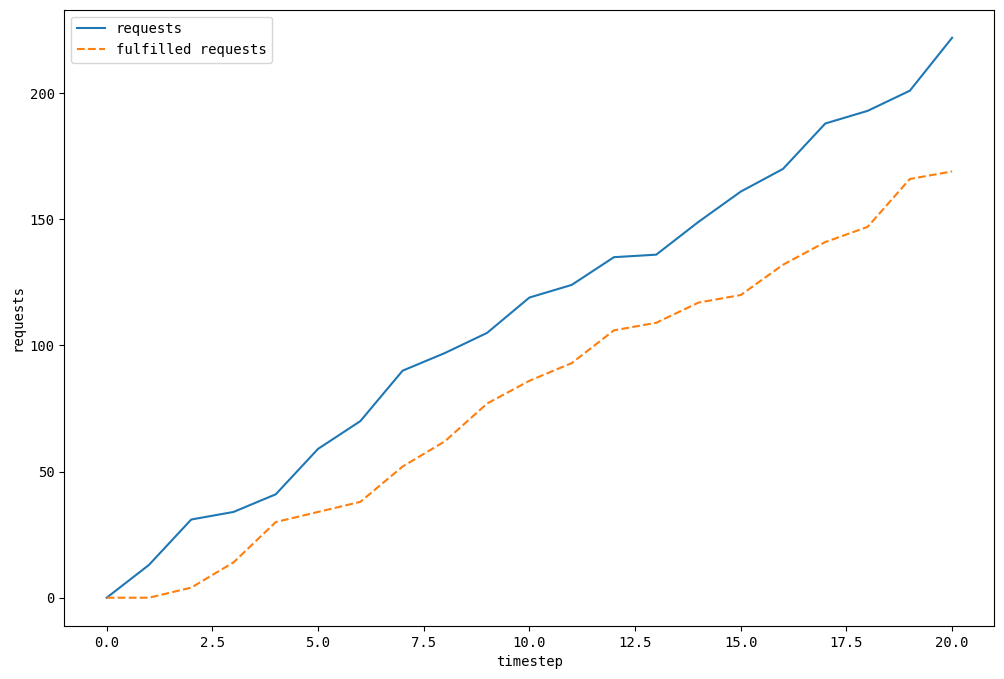

In [23]:
data1 = np.array(total_requests)
data2 = np.array(total_fulfilled_requests)


plt.figure(figsize=(12, 8))

times = np.array([i for i in range(TIMESTEPS)])# + 1)])


plt.plot(times, data1, label='requests', linestyle='-')
plt.plot(times, data2, label='fulfilled requests', linestyle='--')


plt.xlabel('timestep')
plt.ylabel('requests')
plt.legend()

plt.show()